# Data Consolidation
Getting the data from all the different files into one csv.

Game plan from here:
new csv file for generated labels and real labels 
model that I am working on (using lstm model to predict next USER DATA & next activity prediction and create a row for it) concat into singular CSV (don't have to rename files beforehand) 

Two csv files ? 

Possibly use labels to predict next user data 


In [ ]:
# Standard library imports
import gzip
import os
import shutil
import zipfile
import pickle
from threading import Timer

# Data handling and numerical analysis
import pandas as pd
import numpy as np

# Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

# Machine Learning and Deep Learning libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Flatten, BatchNormalization, Reshape, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, LearningRateScheduler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.sequence import pad_sequences, TimeseriesGenerator
from tensorflow.keras.models import load_model, clone_model

from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential
from keras.optimizers import Adam

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from skmultilearn.problem_transform import ClassifierChain

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import warnings
warnings.filterwarnings('ignore')



In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [ ]:
# Making sure ExtraSensory.per_uuid_features_labels.zip exists and is unziped
def unzip(zip_file):
    # Extract to the directory obtained from the zip file name
    zip_extract_to = zip_file.replace('.zip', '')

    # Unzipping
    if os.path.exists(zip_file):
        if not os.path.exists(zip_extract_to):
            os.makedirs(zip_extract_to)
            with zipfile.ZipFile(zip_file, 'r') as zip_ref:
                zip_ref.extractall(zip_extract_to)
            message = "Unzipped successfully."
        else:
            message = "Directory already exists. File might be unzipped."
    else:
        message = "Zip file not found."

    print(message)
    return zip_extract_to


def csv_extract(zip_extract_to):
    # Improved variable name for the directory where the extracted files will be saved
    unzipped_data_dir = f"{zip_extract_to}-Unzipped"

    # Create the unzipped data directory if it does not exist
    if not os.path.exists(unzipped_data_dir):
        os.makedirs(unzipped_data_dir)

    # Extracting .csv.gz files
    extraction_message = ""
    if os.path.exists(zip_extract_to):
        for file in os.listdir(zip_extract_to):
            if file.endswith('.gz'):
                gz_file_path = os.path.join(zip_extract_to, file)
                csv_file_path = os.path.join(unzipped_data_dir, file[:-3])  # Removing '.gz' from filename

                try:
                    with gzip.open(gz_file_path, 'rb') as f_in:
                        with open(csv_file_path, 'wb') as f_out:
                            shutil.copyfileobj(f_in, f_out)
                    extraction_message += f"Extracted {file}\n"
                except Exception as e:
                    extraction_message += f"Error extracting {file}: {e}\n"
    else:
        extraction_message = "Directory with .gz files not found."

    print(extraction_message.strip())

    return unzipped_data_dir


# Function to extract user_id from filename
def extract_user_id(filename):
    return filename.split('.')[0]

def make_one_csv(unzipped_data_dir, COMBINED_FILE):
    # Combining all CSVs into one dataframe
    combined_csv_data = pd.DataFrame()

    if os.path.exists(unzipped_data_dir):
        for file in os.listdir(unzipped_data_dir):
            if file.endswith('.csv'):
                file_path = os.path.join(unzipped_data_dir, file)
                user_id = extract_user_id(file)

                # Read the CSV file and add the user_id column
                csv_data = pd.read_csv(file_path)
                csv_data['user_id'] = user_id

                # Append to the combined dataframe
                combined_csv_data = pd.concat([combined_csv_data, csv_data], ignore_index=True)

                
                #print(f"Processed file: {file} \nCurrent size of combined data: {combined_csv_data.shape}")


        # Check if any data has been combined
        if not combined_csv_data.empty:
            # Save the combined CSV data to a file
            combined_csv_data.to_csv(COMBINED_FILE, index=False)
            print(f"Combined CSV file created at {COMBINED_FILE}.")
        else:
            print("No CSV files found to combine or combined data is empty.")
    else:
        print("Directory with unzipped CSV files not found.")
    return COMBINED_FILE



In [ ]:
COMBINED_FILE = 'ExtraSensory_Combined_User_Data.csv'
if not os.path.exists(COMBINED_FILE):
    # Path of the zip file
    zip_file = 'ExtraSensory.per_uuid_features_labels.zip'
    zip_extract_to = unzip(zip_file)
    unzipped_data_dir = csv_extract(zip_extract_to)
    make_one_csv(unzipped_data_dir, COMBINED_FILE)
else:
    print('Combined file already exists.')


# Data Exploration & Models Creation

In [ ]:
combined_csv_data = pd.read_csv(COMBINED_FILE)
combined_csv_data['timestamp'] = pd.to_datetime(combined_csv_data['timestamp'], unit='s')

In [ ]:
print(combined_csv_data.columns)

# user_id is for us to make sure we have record on source of the data. 

In [ ]:
# Trying to understand columns
def build_hierarchy(columns):
    # Build a nested dictionary representing the hierarchy of columns.
    hierarchy = {}
    for col in columns:
        parts = col.split(':')
        current_level = hierarchy

        for part in parts[:-1]:
            current_level = current_level.setdefault(part, {})
        
        current_level[parts[-1]] = col

    return hierarchy

def format_hierarchy(hierarchy, indent=0):
    # Format the hierarchy into a readable string with indentation.
    result = ""
    for key, value in hierarchy.items():
        prefix = "  " * indent + "- "
        if isinstance(value, dict):
            result += f"{prefix}{key}:\n{format_hierarchy(value, indent + 1)}"
        else:
            result += f"{prefix} {key}\n"
    return result

# Building and formatting the hierarchy
hierarchy = build_hierarchy(combined_csv_data.columns)
formatted_hierarchy = format_hierarchy(hierarchy)
print(formatted_hierarchy)

In [ ]:
# List of label columns to check
label_columns = [col for col in combined_csv_data.columns if col.startswith("label:")]

# Assumption of negatives for ground truths
combined_csv_data[label_columns] = combined_csv_data[label_columns].fillna(0)

combined_csv_data['label_sum_inital'] = combined_csv_data[label_columns].sum(axis=1)
combined_csv_data['label:UNKNOWN'] = (combined_csv_data['label_sum_inital'] == 0).astype(float)
label_columns.append('label:UNKNOWN')
combined_csv_data = combined_csv_data.drop('label_sum_inital', axis=1)
df = combined_csv_data.copy()


# Function to find the label name with value 1
def find_label_name(row):
    for col in label_columns:
        if row[col] == 1:
            return col.split("label:")[1]
    return None

In [ ]:
# Checking ground truth labels for value counts
column_sums = df[label_columns].sum()
column_sums_sorted = column_sums.sort_values(ascending=True)

# Plot setup
plt.figure(figsize=(10, 14)) 
column_sums_sorted.plot(kind='barh')
plt.title('Sum of Each Column in DataFrame')
plt.xlabel('Count')
plt.ylabel('Most Done Activities')
plt.tight_layout()
plt.show()

In [ ]:
# Deleting the other columns
unneeded_columns = ['user_id', 'label_source']
output_columns = [col for col in combined_csv_data.columns if col.startswith('label:')]
input_columns = [col for col in combined_csv_data.columns if col not in output_columns and col not in unneeded_columns]
X_main = df.copy()[input_columns]

In [ ]:
# Checking input variables for missing values
def nan_percentage(df):
    nan_percentage = (df.isna().mean() * 100).round(2)
    nan_percentage_df = pd.DataFrame({'Variable': nan_percentage.index, 'NaN Percentage': nan_percentage.values})
    nan_percentage_df = nan_percentage_df.sort_values(by='NaN Percentage', ascending=True)
    
    # Plot setup
    plt.figure(figsize=(8, 35)) 
    plt.barh(nan_percentage_df['Variable'], nan_percentage_df['NaN Percentage'])
    plt.xlabel('Percentage of Missing Values')
    plt.ylabel('Variables')
    plt.title('Missing Value Percentage by Variable')
    plt.grid(axis='x')
    plt.tight_layout() 
    plt.show()
    return nan_percentage_df

# Checking overall missing percentage
nan_percentage_df = nan_percentage(X_main)

In [ ]:
X_with_users = df.drop(columns=['label_source'])

In [ ]:
users = X_with_users['user_id'].unique()
len(users)

In [ ]:
features = input_columns

In [ ]:
# Initialize a list to store the counts for each user
nan_counts_list = []

# Loop through each user
for user in users:
    # Filter the DataFrame for the current user
    df_user = X_with_users[X_with_users['user_id'] == user]
    
    # Count the NaN values for each feature for the current user and add user_id to the series
    nan_count = df_user[features].isna().sum()
    nan_count['user_id'] = user  # Add user_id to the count
    
    # Append the count series to the list
    nan_counts_list.append(nan_count)

# Convert the list of Series to a DataFrame
nan_counts_per_user = pd.DataFrame(nan_counts_list)

# If needed, set the user_id as the index
nan_counts_per_user.set_index('user_id', inplace=True)


# Plot the heat map
plt.figure(figsize=(30, 30))
sns.heatmap(nan_counts_per_user, annot=False, cmap='Reds')
plt.title('Heatmap of Missing Values per User')
plt.xlabel('Features')
plt.ylabel('Users')
plt.show()

In [ ]:
# Calculate the total number of rows for each user in the original DataFrame
user_total_length = X_with_users.groupby('user_id').size()

# Convert this to a DataFrame or a Series that can be added to nan_counts_per_user
user_total_length_df = user_total_length.to_frame(name='total_length')

# Merge this information with nan_counts_per_user
# Since nan_counts_per_user already has user_id as its index, we can directly add the new column
nan_counts_per_user['total_length'] = user_total_length_df['total_length']

# Now, nan_counts_per_user includes the total_length column

In [ ]:

# Calculate the total NaN count for each feature across all users
total_nan_counts = nan_counts_per_user.sum()

# Assuming `X_with_users` is your original DataFrame and has the same number of entries for each user,
# Calculate the total number of entries for a single feature across all users
total_entries_per_feature = len(X_with_users)  # Or, more specifically, len(users) * average_entries_per_user if varies

# Calculate the percentage of missing data for each feature
percentage_missing = (total_nan_counts / total_entries_per_feature) * 100


# Decide on a threshold for removing columns, e.g., 1%
threshold = 0

# Identify columns that exceed this threshold
columns_to_remove = percentage_missing[percentage_missing > threshold].index.tolist()

print("Removing ", len(columns_to_remove),"columns out of ", len(X_with_users.columns))
# Print out the columns to remove
# print("Columns to remove due to excessive missing data:", columns_to_remove)

features_to_include = [feature for feature in features if feature not in columns_to_remove]

if 'timestamp' in X_with_users.columns:
    X_with_users['timestamp_numeric'] = X_with_users['timestamp'].astype(np.int64) // 10**9
    # Ensure 'timestamp_numeric' is included and 'timestamp' is excluded from features_to_include
    features_to_include = [f for f in features_to_include if f != 'timestamp'] + ['timestamp_numeric']

# Continue with your existing preprocessing...
user_df = X_with_users[X_with_users['user_id'] == users[-1]]
median_values = user_df[features_to_include].median()
user_df = user_df[features_to_include].fillna(median_values)


We performed a threshold check from 0 to 5 percent, testing each percentage, and then proceeded with increments of 5. Each test was conducted with a classifier and a linear model, where 0% consistently performed the best. We also evaluated several LSTM models and the standard techniques of forward fill, mean, median, and mode to address missing values. The median emerged as the second-best method, with the most effective approach being to ignore the values using a threshold of 0.

#### Classifier Detail Check
Testing to see if we need to do Binary Relevance, or Classifier chains. We can also check Label Powerset, but the issue is combinations can become very large since we have 52 labels. 

In [ ]:
combined_csv_data_4_model = combined_csv_data.copy()
combined_csv_data_4_model['timestamp_numeric'] = combined_csv_data_4_model['timestamp'].astype(np.int64) // 10**9
combined_csv_data_4_model = combined_csv_data_4_model.drop(columns=['timestamp'])
X = combined_csv_data_4_model[features_to_include]
y = combined_csv_data_4_model[output_columns]

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [ ]:
plt.figure(figsize = (20,20))
corr_matrix = y.corr(method = 'pearson')  # Compute the correlation matrix

# Flatten the matrix, sort by absolute value while preserving names
corr_flat = corr_matrix.unstack()
corr_flat_sorted = corr_flat.abs().sort_values(ascending=False)

# Remove self-correlations
corr_flat_sorted = corr_flat_sorted[corr_flat_sorted < 1]

# Take the top N correlations for plotting (for simplicity, let's plot all unique pairs)
unique_pairs = corr_flat_sorted.drop_duplicates().head(10)

# Plotting
plt.figure(figsize=(10, 6))
unique_pairs.plot(kind='bar')
plt.title('Top Correlations Between Labels')
plt.xlabel('Label Pairs')
plt.ylabel('Correlation')
plt.xticks(rotation=45, ha='right')
plt.show()

Seems like there is a corrolation, lets do Classifier chains. 

In [ ]:
plt.figure(figsize = (20,20))
corr = y.corr(method = 'pearson')
corr_flat = corr.unstack().sort_values(ascending =False)

sns.heatmap(corr, annot = False, cmap = 'coolwarm')
plt.show()

In [ ]:

combined_csv_data_4_model = combined_csv_data.iloc[:37734,:].copy()
combined_csv_data_4_model['timestamp_numeric'] = combined_csv_data_4_model['timestamp'].astype(np.int64) // 10**9
combined_csv_data_4_model = combined_csv_data_4_model.drop(columns=['timestamp'])
X = combined_csv_data_4_model[features_to_include]
y = combined_csv_data_4_model[output_columns]

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [ ]:
# Initialize Classifier Chain with a RandomForest base classifier
classifier = ClassifierChain(RandomForestClassifier())

# Train the Classifier Chain model
classifier.fit(X_train, y_train)

# Make predictions
predictions = classifier.predict(X_test)

# Note: accuracy_score expects single-label predictions,
# so for multi-label you might use another metric like hamming loss or a subset accuracy function
# Here's an example with a custom subset accuracy for multi-label
def subset_accuracy(y_true, y_pred):
    return (y_true == y_pred).all(axis=1).mean()

print("Subset Accuracy: ", subset_accuracy(y_test, predictions.toarray()))

In [ ]:
user = users[0]

models_data = {
    'models': {},
    'accuracies': {}
}


### Testing to see if creating separate models is computationally expensive.

#### Individual Models

In [ ]:
combined_csv_data_4_model = combined_csv_data.copy()
combined_csv_data_4_model['timestamp_numeric'] = combined_csv_data_4_model['timestamp'].astype(np.int64) // 10**9
combined_csv_data_4_model = combined_csv_data_4_model.drop(columns=['timestamp'])

warnings.simplefilter(action='ignore', category=RuntimeWarning)

counter = 1

for user in users:
    
    user_df = combined_csv_data_4_model[combined_csv_data['user_id'] == user]
    
    print(f'Shape of df of user no. {counter} of id {user} is: {user_df.shape}')
    # Assuming 'combined_csv_data' is your DataFrame
    X = user_df[features_to_include]
    y = user_df[output_columns]
    # Normalize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Initialize Classifier Chain with a RandomForest base classifier
    classifier = ClassifierChain(RandomForestClassifier())
    # Train the Classifier Chain model
    classifier.fit(X_train, y_train)
    models_data['models'][user] = classifier
     # Make predictions
    predictions = classifier.predict(X_test)
    # Evaluate your model
    # Example: Using accuracy score, you can choose other metrics as appropriate
    from sklearn.metrics import accuracy_score

    # Note: accuracy_score expects single-label predictions,
    # so for multi-label you might use another metric like hamming loss or a subset accuracy function
    # Here's an example with a custom subset accuracy for multi-label
    def subset_accuracy(y_true, y_pred):
        return (y_true == y_pred).all(axis=1).mean()
    accuracy = subset_accuracy(y_test, predictions.toarray())
    models_data['accuracies'][user] = accuracy
    print(f"Subset Accuracy for {user}: ", accuracy)
    with open('clfs_2.pkl', 'wb') as file:
        pickle.dump(models_data, file)
    print('File Updated')
    counter = counter +1

#### General Model

In [ ]:
print(f'Shape of df is: {combined_csv_data_4_model.shape}')
# Assuming 'combined_csv_data' is your DataFrame
X = combined_csv_data_4_model[features_to_include]
y = combined_csv_data_4_model[output_columns]
# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize Classifier Chain with a RandomForest base classifier
classifier = ClassifierChain(RandomForestClassifier())
# Train the Classifier Chain model
classifier.fit(X_train, y_train)
models_data['models']["all"] = classifier
    # Make predictions
print('Processing predictions for X_test.')
predictions = classifier.predict(X_test)

def subset_accuracy(y_true, y_pred):
    return (y_true == y_pred).all(axis=1).mean()
print('Processing accuracy.')

accuracy = subset_accuracy(y_test, predictions.toarray())
models_data['accuracies']["all"] = accuracy
print(f"Subset Accuracy for all together data is: ", accuracy)
with open('all_clfs_2.pkl', 'wb') as file:
    pickle.dump(models_data, file)
print('File Updated')

For the IoT, we will use the general model and use the individual model once the accuracy or individual model passes the general model. Both of these iterations are to predict the current labels using sensor data. 

## Using classifier chains to generate predictions for LSTM
Let's use the success of our classifier chains for individual users to generate predictions for our LSTM model. First we'll prepare the predictions generated by the classifier chains.

In [ ]:
# Preparing dataset for predictions
combined_csv_data_4_model = combined_csv_data.copy()
combined_csv_data_4_model['timestamp_numeric'] = pd.to_datetime(combined_csv_data_4_model['timestamp']).astype(np.int64) // 10**9
combined_csv_data_4_model = combined_csv_data_4_model.drop(columns=['timestamp'])

# Creating user_specific_data dictionary
user_specific_data = {}
for user in users:
    user_df = combined_csv_data_4_model[combined_csv_data_4_model['user_id'] == user]
    
    # Sorting user_df by 'timestamp_numeric' to ensure temporal order
    user_df = user_df.sort_values(by='timestamp_numeric')
    user_specific_data[user] = user_df

In [ ]:
# Loading models from disk
with open('clfs_2.pkl', 'rb') as file:
    models_data = pickle.load(file)

# Defining function to generate predictions using classifier chains
def generate_classifier_chain_predictions(user_df, classifier_chain_model):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(user_df[features_to_include])

    # Generating predictions
    predictions = classifier_chain_model.predict(X_scaled)
    return predictions.toarray()

user_predictions = {}
for user_id, user_data in user_specific_data.items():
    user_df = user_specific_data[user_id]
    classifier_chain_model = models_data['models'][user_id]
    user_predictions[user_id] = generate_classifier_chain_predictions(user_df, classifier_chain_model)

# Now 'user_predictions' contains predictions for each user that can be used as input for the LSTM

In [ ]:
# # Checking if all predictions are 2D arrays with a consistent second dimension
for user_id, predictions in user_predictions.items():
    print(f"User ID: {user_id}, Shape: {np.array(predictions).shape}")

consistent_shape = True
second_dim = None

for predictions in user_predictions.values():
    np_predictions = np.array(predictions)
    if second_dim is None:
        second_dim = np_predictions.shape[1] if len(np_predictions.shape) > 1 else 0
    elif len(np_predictions.shape) <= 1 or np_predictions.shape[1] != second_dim:
        consistent_shape = False
        break

if consistent_shape and second_dim:
    print(f"All predictions are 2D arrays with a consistent second dimension: {second_dim}")
else:
    print("Predictions are not consistent 2D arrays or have varying second dimensions.")


In [ ]:
# Padding and stacking for LSTM input shpae
max_sequence_length = max([len(predictions) for predictions in user_predictions.values()])
X_lstm = pad_sequences(list(user_predictions.values()), maxlen=max_sequence_length, padding='post', dtype='float64')
original_lengths = [len(predictions) for predictions in user_predictions.values()]
X_lstm = X_lstm.reshape((X_lstm.shape[0], X_lstm.shape[1], 52))

print(f"LSTM input shape: {X_lstm.shape}")

In [ ]:
# Creating user specific timestamp dictionaries
user_specific_timestamps = {}
for user in users:
    user_df = combined_csv_data[combined_csv_data['user_id'] == user]
    user_df = user_df.sort_values(by='timestamp')
    user_specific_timestamps[user] = user_df['timestamp'].values

# Padding the timestamps to have the same length as the sequences
padded_timestamps = pad_sequences(list(user_specific_timestamps.values()), maxlen=max_sequence_length, padding='post', value=None, dtype='float64')  # Use "NONE" as a placeholder for non-real timestamps
original_timestamp_lengths = [len(ts) for ts in user_specific_timestamps.values()]

# Now 'padded_timestamps' contains the ordered timestamps for each user

Now let's prepare the LSTM model

In [ ]:
# Initializing model
model = Sequential([
    LSTM(50, input_shape=(X_lstm.shape[1], X_lstm.shape[2]), return_sequences=True),
    Dropout(0.5),
    LSTM(50, return_sequences=False),
    Dropout(0.5),
    Dense(100, activation='relu'),
    Dense(len(label_columns), activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

In [ ]:
# Extracting user labels
user_labels = {}
for user_id in users:
    user_labels_df = combined_csv_data[combined_csv_data['user_id'] == user_id]
    labels_array = user_labels_df[label_columns].values 
    user_labels[user_id] = labels_array

In [ ]:
# Checking shape for padding
for user_id, labels in user_labels.items():
    print(f"User ID: {user_id}, Labels shape: {labels.shape}")

In [ ]:
# Padding labels
padded_labels = []

for user_id, labels in user_labels.items():
    # Padding the user's label array to have the same length as the max_sequence_length
    padded_label = pad_sequences([labels], maxlen=max_sequence_length, padding='post', dtype='float64')[0]
    padded_labels.append(padded_label)

y_lstm = np.array(padded_labels)

print(f"Padded labels shape: {y_lstm.shape}")

In [ ]:
# We'll reduce the dimensionality of y_lstm to just two dimensions: (number of samples, number of labels)
y_lstm = y_lstm[:, 0, :] 

print(f"Adjusted labels shape: {y_lstm.shape}")

In [ ]:
# Splitting data for training & validation
X_train, X_val, y_train, y_val = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42)

In [ ]:
# Training model
history = model.fit(
    X_train, 
    y_train, 
    epochs=10, 
    batch_size=64, 
    validation_data=(X_val, y_val),
    verbose=1
)

# Evaluating model
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)

print(f'Validation accuracy: {val_acc}, Validation loss: {val_loss}')

In [ ]:
# Generating predictions for the validation set
predictions = model.predict(X_val)

# Applying threshold to convert propabilities to binary values
binary_predictions = (predictions > 0.5).astype(int)

# Lets examine a few predictions to get a sense of what our model is doing 
for i, prediction in enumerate(binary_predictions[:5]):
    print(f"Prediction for sample {i}: {prediction}")

In [ ]:
# Lets map these to the label names so we know what the predictions mean 
for i, prediction in enumerate(binary_predictions[:5]):
    labeled_prediction = dict(zip(label_columns, prediction))
    print(f"Prediction for sample {i}: {labeled_prediction}")

In [ ]:
# Load all predictions into a dataframe
predictions_df = pd.DataFrame(binary_predictions, columns=label_columns)
predictions_df.to_csv('LSTM_model_predictions_with_labels.csv', index=False)

## Adding linear model for input predictions
Let's see if we can leverage the predicted labels from our LSTM model to use a linear model for input predictions. 

In [ ]:
# Initializing model
X = y_lstm 
y = X_lstm.reshape(X_lstm.shape[0], -1) 

# Splitting the dataset for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Making predictions - predicting features based on labels
y_pred = linear_model.predict(X_test)

# Evaluating model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

In [ ]:
# Saving predictions to csv
predictions_df = pd.DataFrame(y_pred, columns=[f'Feature_{i}' for i in range(y_pred.shape[1])])
predictions_df.to_csv('predicted_features.csv', index=False)
print("Predictions saved to 'predicted_features.csv'.")

Old numbers
Shape of df is: (377346, 280)
Processing predictions for X_test.
Processing accuracy.
Subset Accuracy for all together data is:  0.40275606201139524
File Updated

In [ ]:
# Define your MLP model
class MultiTaskMLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(MultiTaskMLP, self).__init__()
        self.layer1 = nn.Linear(input_size, 64)
        self.layer2 = nn.Linear(64, 64)
        self.output_layer = nn.Linear(64, output_size)
    
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.output_layer(x)
        return x

# Placeholder for models and accuracies
models_data_2 = {
    'models': {},
    'accuracies': {}
}

# Loop through each user
for user in users:
    user_df = combined_csv_data_4_model[combined_csv_data_4_model['user_id'] == user]
    X = user_df[features_to_include].values
    y = user_df[output_columns].values
    
    # Normalize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    
    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.FloatTensor(y_train)
    X_test_tensor = torch.FloatTensor(X_test)
    y_test_tensor = torch.FloatTensor(y_test)
    
    # DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    # Initialize the model
    model = MultiTaskMLP(input_size=X_train_tensor.shape[1], output_size=y_train_tensor.shape[1])
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Training loop
    for epoch in range(10):  # Adjust epochs as needed
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
    # Evaluation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            predicted = torch.sigmoid(outputs) > 0.5  # Threshold at 0.5
            total += labels.size(0)
            correct += (predicted == labels).float().mean()
    accuracy = correct / total
    
    # Store the model and accuracy
    models_data_2['models'][user] = model.state_dict()  # Store state dict for minimal size
    models_data_2['accuracies'][user] = accuracy.item()
    print(f"User {user}: Accuracy = {accuracy.item():.4f}")

# Save the models and accuracies
with open('mlp_models.pkl', 'wb') as file:
    pickle.dump(models_data_2, file)


In [ ]:
# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(combined_csv_data_4_model[features_to_include])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, combined_csv_data_4_model[output_columns], test_size=0.2, random_state=42)


# Convert dataset to tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train.values)  # For multi-label
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test.values)  # For multi-label


# DataLoader setup
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Model setup
model = nn.Sequential(
    nn.Linear(len(features_to_include), 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Linear(64, len(output_columns))
)

# Loss and optimizer setup
criterion = nn.BCEWithLogitsLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
model.train()
for epoch in range(10):  # Number of epochs
    for inputs, labels in train_loader:
        lr = 0.0001 * (epoch + 1)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/10, Loss: {loss.item():.4f}')

# Testing loop
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predicted = torch.sigmoid(outputs) > 0.5  # Applying sigmoid and threshold for multi-label
        total += labels.size(0)
        correct += (predicted == labels.byte()).all(dim=1).sum().item()  # Adjust for multi-label accuracy
accuracy = 100 * correct / total

print(f'Accuracy: {accuracy:.2f}%')


In [ ]:
s1 = MinMaxScaler(feature_range=(-1,1))
user_df_scaled = s1.fit_transform(user_df)
user_df_scaled = pd.DataFrame(user_df_scaled, columns=features_to_include)

# Create sequences
look_back = 4
generator = TimeseriesGenerator(user_df_scaled.values, user_df_scaled.values,
                                length=look_back, batch_size=1)
def create_lstm_model(input_shape, num_features):
    model = Sequential([
        LSTM(units = num_features, activation='relu', input_shape=input_shape, return_sequences=True),
        Dropout(0.2),
        Dense(num_features),
        LSTM(units=num_features, return_sequences=True),
        Dropout(0.2),        
        LSTM(units=num_features, return_sequences=True),
        Dense(num_features),
        Dropout(0.2),
        LSTM(units=num_features, return_sequences=True),
        Dense(num_features),
        Dropout(0.2),        
        LSTM(units=num_features),
        Dense(num_features),
        Activation('linear'),
        
    ])
    model.compile(optimizer='adam', loss='mse', metrics = ['accuracy'])  
    return model
model_path = 'LSTM_next_model.h5'
# Define and compile the LSTM model
model = create_lstm_model((look_back, len(features_to_include)), len(features_to_include))

import keras
if os.path.exists(model_path):
    load_model(model_path)
else:

    model.fit(generator, epochs=1) 
    model.save(model_path)

In [ ]:
def predict_from_df(df, model, features_to_include, look_back=4):
    df_filtered = df[features_to_include]
    
    if len(df_filtered) >= look_back:
        # Extract the last `look_back` rows for the prediction
        last_sequences = df_filtered[-look_back:].values.reshape((1, look_back, len(features_to_include)))
    else:
        raise ValueError(f"DataFrame must have at least {look_back} rows for prediction.")
    
    # Predict the next row using the LSTM model
    predictions = model.predict(last_sequences)
    
    
    return predictions

def compare_predictions_with_actual(df, model, features_to_include, look_back=3):
    predictions = predict_from_df(user_df.iloc[1:5], model, features_to_include, look_back)
    predictions = s1.inverse_transform(predictions)
    actual_values = user_df.iloc[4][features_to_include].values  # Adjust index if needed
    
    return predictions, actual_values

# Assuming 'user_df' is already preprocessed appropriately, including scaling
predictions, actual_values = compare_predictions_with_actual(user_df, model, features_to_include, look_back=4)

# Now you can compare 'predictions' with 'actual_values'
# Note: If your data was scaled, you might need to inverse scale both predictions and actual values before comparison

print(f"{'Predictions':<15}   | {'Actual Values':<15} | {'Diff':<15} | {'Diff %':<15}")
print("-" * 47)  # Adjust the number based on the width of your columns

j = 0
for i in range(len(predictions[j])):
    p = predictions[j][i]
    a = actual_values[i]
    diff = a-p
    diff_p = ((p-a)/a)*100
    print(f"{p:.6f}{'':<9} | {a:<15} | {diff:.6f} | {diff_p:.6f}")



# Experimentations

This section includes all the code tested during the model creation. Different configurations along with different models.

## Testing CNN And LSTM for prediction

In [ ]:

# Adjust the input shape according to your dataset
input_shape = (X_train.shape[1], 1)  # Assuming non-sequential data for simplicity

model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    # Instead of Flatten, use Reshape or adjust the model so it's suitable for LSTM input
    # Reshape example (adjust the target shape according to your needs):
    # This line is illustrative; actual reshaping depends on the output shape of the previous layer
    Reshape((-1, 128)),  # Adjust the target shape
    LSTM(50, return_sequences=False),  # If you want the LSTM to output a sequence, set return_sequences=True
    Dropout(0.5),
    Dense(100, activation='relu'),
    Dense(len(label_columns), activation='sigmoid')  # Use 'sigmoid' for multi-label classification
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',  # Use 'binary_crossentropy' for multi-label classification
              metrics=['accuracy'])

model.summary()


In [ ]:
# Reshape data for CNN if needed
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [ ]:
# For arrays, assuming X_train_reshaped and y_train are your features and labels respectively
subset_size = 100  # Choose a small size for quick tests
X_train_subset = X_train_reshaped[:subset_size]
y_train_subset = y_train[:subset_size]


In [ ]:
# Testing Shape Issues
model_name = 'first_try.h5'
if os.path.exists(model_name):
    model = load_model(model_name)
else:
    history = model.fit(X_train, y_train,
                    epochs=1,  
                    batch_size=64, 
                    validation_split=0.2, 
                    verbose=1)  

    model.save(model_name)

test_loss, test_acc = model.evaluate(X_test_reshaped, y_test, verbose=2)
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')


In [ ]:

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * math.exp(-0.1)

callback = LearningRateScheduler(scheduler)

model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Reshape((-1, 128)),  # Adjust based on the output shape of the previous layer
    Bidirectional(LSTM(100, return_sequences=False)),
    Dropout(0.5),
    Dense(100, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dense(len(label_columns), activation='sigmoid')  # Adjust based on your label columns
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

model_name = 'second_try.h5'
if os.path.exists(model_name):
    model = load_model(model_name)
else:
    model.fit(X_train, y_train, epochs=1,batch_size=128,  validation_split=0.2)
    model.save(model_name)

test_loss, test_acc = model.evaluate(X_test_reshaped, y_test, verbose=2)
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')


In [ ]:
# Example fitting with callbacks
# model.fit(X_train, y_train, epochs=1,batch_size=128,  validation_split=0.2)


In [ ]:

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * math.exp(-0.1)

callback = LearningRateScheduler(scheduler)

model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Reshape((-1, 128)),  # Adjust based on the output shape of the previous layer
    Bidirectional(LSTM(100, return_sequences=False)),
    Dropout(0.5),
    Dense(100, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dense(len(label_columns), activation='sigmoid')  # Adjust based on your label columns
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


In [ ]:
model_name = 'third_try.h5'
if os.path.exists(model_name):
    model = load_model(model_name)
else:
    model.fit(X_train, y_train, epochs=1,batch_size=128,  validation_split=0.2)
    model.save(model_name)
    # Evaluate the model
    test_loss, test_acc = model.evaluate(X_test_reshaped, y_test, verbose=2)
    print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')

test_loss, test_acc = model.evaluate(X_test_reshaped, y_test, verbose=2)
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')


In [ ]:
model_name = 'third_try_2.h5'
if os.path.exists(model_name):
    model = load_model(model_name)
else:
    model.fit(X_train, y_train, epochs=1,batch_size=20,  validation_split=0.2)
    model.save(model_name)
    # Evaluate the model
    test_loss, test_acc = model.evaluate(X_test_reshaped, y_test, verbose=2)
    print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Dropout, Reshape
from tensorflow.keras.optimizers import Adam

# Adjust the input shape according to your dataset
input_shape = (X_train.shape[1], 1)  # Assuming non-sequential data for simplicity

model = Sequential([
    LSTM(len(label_columns), return_sequences=True, input_shape=input_shape),  # If you want the LSTM to output a sequence, set return_sequences=True
    Dropout(0.2),
    Conv1D(filters=len(label_columns), kernel_size=2, activation='relu'),
    MaxPooling1D(pool_size=7),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    # Instead of Flatten, use Reshape or adjust the model so it's suitable for LSTM input
    # Reshape example (adjust the target shape according to your needs):
    # This line is illustrative; actual reshaping depends on the output shape of the previous layer
    Reshape((-1, 128)),  # Adjust the target shape
    LSTM(50, return_sequences=False),  # If you want the LSTM to output a sequence, set return_sequences=True
    Dropout(0.2),
    Dense(100, activation='relu'),
    Dense(len(label_columns), activation='sigmoid')  # Use 'sigmoid' for multi-label classification
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',  # Use 'binary_crossentropy' for multi-label classification
              metrics=['accuracy'])

model.summary()



In [ ]:
model_name = 'fourth_try_2.h5'
if os.path.exists(model_name):
    model = load_model(model_name)
else:
    model.fit(X_train, y_train, epochs=1, validation_split=0.2)
    model.save(model_name)

In [ ]:
y_train.shape[1]

In [ ]:


scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Adjust the input shape according to your dataset
# For LSTM, input should be in the form of (samples, timesteps, features)
# Assuming each sample is a sequence of vectors
input_shape = (X_train.shape[1], 1)  # Adjust '1' if your data is already in sequences

model = Sequential()
# Start with an LSTM layer to process sequences
model.add(LSTM(units=64, return_sequences=True, input_shape=input_shape))
model.add(Dropout(0.2))

# Followed by CNN layers for feature extraction from sequences processed by LSTM
model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# Flatten the output to feed into a dense layer
model.add(Flatten())
# Additional dense layers or LSTM layers can be added here if needed
# Example: model.add(LSTM(50, return_sequences=False))

model.add(Dense(100, activation='relu'))
model.add(Dense(y_train.shape[1], activation='sigmoid'))  # Assuming 'y' is one-hot encoded for multi-label classification

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',  # Adjust the loss function as per your problem
              metrics=['accuracy'])

model.summary()


In [ ]:
model_name = 'fifth_try_3.h5'
if os.path.exists(model_name):
    model = load_model(model_name)
else:
    model.fit(X_train, y_train, epochs=1, validation_split=0.2)
    model.save(model_name)

In [ ]:

# Assuming 'X' and 'y' are your features and labels, respectively

# Data Preprocessing
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)  # Normalize features

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Model Definition
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    Conv1D(64, kernel_size=2, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(100, activation='relu'),
    Dense(y_train.shape[1], activation='sigmoid')  # Output layer
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])  # Add other metrics as needed

# Custom Callback for Precision, Recall, F1 Score
class MetricsCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        val_predict = (np.asarray(self.model.predict(X_test))).round()
        val_targ = y_test
        _val_precision = precision_score(val_targ, val_predict, average='micro')
        _val_recall = recall_score(val_targ, val_predict, average='micro')
        _val_f1 = f1_score(val_targ, val_predict, average='micro')
        print(f' — val_precision: {_val_precision:.4f} — val_recall: {_val_recall:.4f} — val_f1: {_val_f1:.4f}')

# Model Training
model.fit(X_train, y_train,
          validation_data=(X_test, y_test),
          epochs=1,  # Adjust number of epochs as necessary
          batch_size=32,  # Adjust batch size as necessary
          callbacks=[MetricsCallback()])

# Note: This is a simplified example. In practice, you might need to adjust the model architecture, preprocessing steps,
# and training parameters based on the specifics of your dataset and task.

model_name = 'fifth_try_4.h5'
if os.path.exists(model_name):
    model = load_model(model_name)
else:
    model.fit(X_train, y_train, validation_split=0.2, epochs=1, batch_size=32, callbacks=[MetricsCallback()])


In [ ]:
hierarchy = build_hierarchy(X.columns)
formatted_hierarchy = format_hierarchy(hierarchy)
print(formatted_hierarchy)

## Testing Batch Sizes

In [ ]:

def find_best_batch_size(model, X_train, y_train, X_test, y_test, batch_sizes):
    """
    Trains a given model using different batch sizes, evaluates performance on test data,
    stores each trained model, and returns the best batch size along with its accuracy and a dictionary of models.

    Parameters:
    - model: The initial model to be trained.
    - X_train, y_train: Training data and labels.
    - X_test, y_test: Test data and labels.
    - batch_sizes: List of batch sizes to test.

    Returns:
    - best_batch_size: The batch size yielding the highest accuracy on test data.
    - best_acc: The highest accuracy achieved on test data.
    - models_dict: A dictionary of saved model filenames keyed by their batch sizes.
    """
    models_dict = {}
    best_acc = 0
    best_batch_size = None

    for batch_size in batch_sizes:
        print(f"Training with batch size: {batch_size}")
        # Clone the original model architecture for a fair comparison
        model_clone = clone_model(model)
        model_clone.compile(optimizer=model.optimizer, loss=model.loss, metrics=model.metrics)
        
        # Fit the model
        model_clone.fit(X_train, y_train,
                        epochs=2, 
                        batch_size=batch_size,
                        validation_split=0.2,
                        verbose=1)
        
        # Evaluate the model
        test_loss, test_acc = model_clone.evaluate(X_test, y_test, verbose=2)
        print(f"Test accuracy: {test_acc}, Test loss: {test_loss}")
        
        # Save the model
        model_file_name = f'ExtraSensory_CNN_LSTM_bs{batch_size}.h5'
        model_clone.save(model_file_name)
        models_dict[batch_size] = model_file_name
        
        # Update best model if current is better
        if test_acc > best_acc:
            best_acc = test_acc
            best_batch_size = batch_size

    print(f"Best Batch Size: {best_batch_size} with Test Accuracy: {best_acc}")
    return best_batch_size, best_acc, models_dict

# Example usage:
batch_sizes = [128, 64, 16, 4, 1, None] 
# Call the function and store its return values
best_batch_size, best_acc, models_dict = find_best_batch_size(model, X_train_reshaped, y_train, X_test_reshaped, y_test, batch_sizes)

# Now `models_dict` is available outside of the function
print("Available models and their batch sizes:")
for batch_size, model_path in models_dict.items():
    print(f"Batch Size: {batch_size}, Model Path: {model_path}")

# You can load any model from `models_dict` for further use
# selected_model_path = models_dict[best_batch_size]
# loaded_model = load_model(selected_model_path)


In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test_reshaped, y_test, verbose=2)
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')


In [ ]:
model.save('ExtraSensory_CNN_LSTM_Model_v2.h5')


In [ ]:
# Train the model
history = model.fit(X_train_reshaped, y_train,
                    epochs=10, 
                    batch_size=64,
                    validation_split=0.2,
                    verbose=1)

In [ ]:
# Train the model
history = model.fit(X_train_reshaped, y_train,
                    epochs=2, 
                    batch_size=20,
                    validation_split=0.2,
                    verbose=1)

In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test_reshaped, y_test, verbose=2)
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')


In [ ]:
model.save('ExtraSensory_CNN_LSTM_Model_v2_bs_20.h5')


In [ ]:
# Train the model
history = model.fit(X_train_reshaped, y_train,
                    epochs=2, 
                    batch_size=2,
                    validation_split=0.2,
                    verbose=1)

In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test_reshaped, y_test, verbose=2)
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')


In [ ]:
model.save('ExtraSensory_CNN_LSTM_Model_v2_bs_2.h5')


In [ ]:
# Train the model
history = model.fit(X_train_reshaped, y_train,
                    epochs=2, 
                    validation_split=0.2,
                    verbose=1)
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test_reshaped, y_test, verbose=2)
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')
model.save('ExtraSensory_CNN_LSTM_Model_v2_bs_1.h5')


## Testing Thresholds

In [ ]:

# Calculate the total NaN count for each feature across all users
total_nan_counts = nan_counts_per_user.sum()

# Assuming `X_with_users` is your original DataFrame and has the same number of entries for each user,
# Calculate the total number of entries for a single feature across all users
total_entries_per_feature = len(X_with_users)  # Or, more specifically, len(users) * average_entries_per_user if varies

# Calculate the percentage of missing data for each feature
percentage_missing = (total_nan_counts / total_entries_per_feature) * 100


def testing_threshold(threshold, testing_user, fill_type= 'ffill', epochs = 1 ):

    # Decide on a threshold for removing columns, e.g., 1%
    threshold = threshold

    # Identify columns that exceed this threshold
    columns_to_remove = percentage_missing[percentage_missing > threshold].index.tolist()

    print("Removing ", len(columns_to_remove),"columns out of ", len(X_with_users.columns))
    # Print out the columns to remove
    # print("Columns to remove due to excessive missing data:", columns_to_remove)

    features_to_include = [feature for feature in features if feature not in columns_to_remove]

    # First User 
    user_df = X_with_users[X_with_users['user_id'] == users[testing_user]]
    
    if fill_type == 'ffill':
    # Forward fill
        user_df = user_df[features_to_include].ffill()
    elif fill_type == 'mean':
        # Fill missing values with the mean of each column
        mean_values = user_df[features_to_include].mean()
        user_df = user_df[features_to_include].fillna(mean_values)
    elif fill_type == 'median':
        # Fill missing values with the median of each column
        median_values = user_df[features_to_include].median()
        user_df = user_df[features_to_include].fillna(median_values)
    elif fill_type == 'zero':
        # Fill missing values with zero
        user_df = user_df[features_to_include].fillna(0)
    else:
        # If no valid fill_type is provided, print a warning or fill with a default method
        print("Invalid fill_type. No changes made to user_df.")

    scaler = StandardScaler()
    user_df[features_to_include] = scaler.fit_transform(user_df)

    # Define LSTM model architecture
    def create_lstm_model(input_shape):
        model = Sequential([
            LSTM(50, activation='relu', input_shape=input_shape),
            Dense(len(features_to_include), activation='relu') 
        ])
        model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001, clipvalue=0.5), loss='mse')

        return model


    # Assuming timestamps are sorted; if not, sort user_df by timestamp here
    user_df.sort_values('timestamp', inplace=True)

    # Convert user_df to sequences for LSTM
    look_back = 3 
    generator = TimeseriesGenerator(user_df[features_to_include].values, user_df[features_to_include].values,
                                    length=look_back, batch_size=1)

    # Create and train LSTM model on the selected user's data
    model = create_lstm_model((look_back, len(features_to_include)))
    model.fit(generator, epochs=epochs, verbose=1)  # Adjust epochs and verbosity as needed

    return model, features_to_include


In [ ]:
models , features_for_model = {} , {}
model_name = "threshold0_median_epoch1"
models[model_name], features_for_model[model_name]  = testing_threshold(0, -1, fill_type = 'median')
best_model_one_so_far = 'threshold0_median_epoch1'
print(features_for_model[best_model_one_so_far])


In [ ]:
## Testing


def predict_from_df(df, model, features_to_include, look_back=3):
    """
    Process the given DataFrame and predict the next value using the LSTM model.
    
    Parameters:
    - df: DataFrame to process and predict from.
    - model: Trained LSTM model to use for predictions.
    - features_to_include: List of feature names to include in the prediction.
    - look_back: Number of previous time steps to use as input for predictions.
    
    Returns:
    - predictions: Predicted values for the next time step.
    """
    # Ensure the DataFrame contains the necessary features
    if not all(feature in df.columns for feature in features_to_include):
        raise ValueError("DataFrame missing required features")
    
    # Fill missing values with median
    df_filled = df[features_to_include].fillna(df[features_to_include].median())
    
    # Scale features
    scaler = StandardScaler().fit(df_filled)
    df_scaled = scaler.transform(df_filled)
    
    # Create sequences
    sequences = np.array([df_scaled[i - look_back:i] for i in range(look_back, len(df_scaled) + 1)])
    
    # Predict using the LSTM model
    predictions = model.predict(sequences)
    
    return predictions



# Example of how to use the function
# Ensure 'model', 'features_to_include', and 'look_back' are defined as per your model's training setup
predictions = predict_from_df(df_user[features_for_model[model_name]].iloc[1:4],  models[best_model_one_so_far], features_for_model[best_model_one_so_far], look_back=3)
print(predictions)

In [ ]:
print(features_for_model[model_name])
df_user[features_for_model[model_name]].iloc[4].values

In [ ]:
models_with_threshhold = {}
features_to_include = {}
for i in range(6):
    print("for threshold: ", i)
    models_with_threshhold[i], features_to_include[i] = testing_threshold(i, -1)

In [ ]:
fill_options = ['mean', 'median', 'zero']
for fill in fill_options:
    print("Checking different fills at 5 threshhold with ", fill, ' fill option')
    models_with_threshhold[fill], features_to_include[fill] = testing_threshold(5, -1, fill_type = fill)

### Testing epoch = 2

In [ ]:
model_name = "threshold0_median_epoch2"
models_with_threshhold[model_name], features_to_include[model_name]  = testing_threshold(0, -1, fill_type = 'median', epochs= 2)


#### We will go with the lowest threshold and with median fill option.

In [ ]:
model_name = "threshold0_median_epoch1"
models_with_threshhold[model_name], features_to_include[model_name]  = testing_threshold(0, -1, fill_type = 'median')


In [ ]:
best_model_one_so_far = 'threshold0_median_epoch1'
print(features_to_include[best_model_one_so_far])

In [ ]:

def predict_from_df(df, model, features_to_include, look_back=3):
    """
    Process the given DataFrame and predict the next value using the LSTM model.
    
    Parameters:
    - df: DataFrame to process and predict from.
    - model: Trained LSTM model to use for predictions.
    - features_to_include: List of feature names to include in the prediction.
    - look_back: Number of previous time steps to use as input for predictions.
    
    Returns:
    - predictions: Predicted values for the next time step.
    """
    # Ensure the DataFrame contains the necessary features
    if not all(feature in df.columns for feature in features_to_include):
        raise ValueError("DataFrame missing required features")
    
    # Fill missing values with median
    df_filled = df[features_to_include].fillna(df[features_to_include].median())
    
    # Scale features
    scaler = StandardScaler().fit(df_filled)
    df_scaled = scaler.transform(df_filled)
    
    # Create sequences
    sequences = np.array([df_scaled[i - look_back:i] for i in range(look_back, len(df_scaled) + 1)])
    
    # Predict using the LSTM model
    predictions = model.predict(sequences)
    
    return predictions

# Example of how to use the function
# Ensure 'model', 'features_to_include', and 'look_back' are defined as per your model's training setup
predictions = predict_from_df(df_user.iloc[1:4],  models_with_threshhold[best_model_one_so_far], features_to_include[best_model_one_so_far], look_back=3)
print(predictions)


In [ ]:
# Calculate the total NaN count for each feature across all users
total_nan_counts = nan_counts_per_user.sum()

# Assuming `X_with_users` is your original DataFrame and has the same number of entries for each user,
# Calculate the total number of entries for a single feature across all users
total_entries_per_feature = len(X_with_users)  # Or, more specifically, len(users) * average_entries_per_user if varies

# Calculate the percentage of missing data for each feature
percentage_missing = (total_nan_counts / total_entries_per_feature) * 100

# Decide on a threshold for removing columns, e.g., 1%
threshold = 0

# Identify columns that exceed this threshold
columns_to_remove = percentage_missing[percentage_missing > threshold].index.tolist()

print(len(columns_to_remove),"out of ", len(X_with_users.columns))
# Print out the columns to remove
print("Columns to remove due to excessive missing data:", columns_to_remove)

features = [feature for feature in features if feature not in columns_to_remove]



In [ ]:
nan_count = df_user[features].isna().sum()
nan_count_sorted = nan_count.sort_values(ascending=False)
print(len(nan_count_sorted))
nan_count_sorted

In [ ]:
# First User 

# Add more features as necessary
df_user = df_user[features].fillna(method='ffill')
scaler = StandardScaler()
df_user[features] = scaler.fit_transform(df_user)

# Define LSTM model architecture
def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, activation='relu', input_shape=input_shape),
        Dense(1) 
    ])
    model.compile(optimizer=Adam(learning_rate=0.001, clipvalue=0.5), loss='mse')  # Apply gradient clipping

    return model


# Assuming timestamps are sorted; if not, sort user_data by timestamp here
df_user.sort_values('timestamp', inplace=True)

# Convert user_data to sequences for LSTM
look_back = 5  
generator = TimeseriesGenerator(df_user[features].values, df_user[features].values,
                                length=look_back, batch_size=1)

# Create and train LSTM model on the selected user's data
model = create_lstm_model((look_back, len(features)))
model.fit(generator, epochs=2, verbose=1)  # Adjust epochs and verbosity as needed


In [ ]:
df_test = X_with_users[X_with_users['user_id'] == users[3]]

In [ ]:
# Predict and fill missing values function
def predict_and_fill_missing_values(data, model, feature_columns, look_back):
    for i in range(len(data)):
        if pd.isnull(df.loc[i, feature_columns]).any():  # Check if any feature value is missing
            input_seq = data[feature_columns].iloc[max(i-look_back, 0):i].values
            input_seq = scaler.transform(input_seq)  # Normalize the input
            input_seq = input_seq.reshape((1, look_back, len(feature_columns)))
            predicted_value = model.predict(input_seq)
            data.loc[i, feature_columns] = scaler.inverse_transform(predicted_value)  # Fill with prediction
    return data



# Fill missing values in the original DataFrame
df_filled_with_predictions = predict_and_fill_missing_values(df_test, model, features, look_back)

In [ ]:
for column in features:
    # Find indices with missing values for the current column
    missing_indices = df_test[df_test[column].isnull()].index.tolist()
    
    for missing_index in missing_indices:
        # Check if there are enough previous data points
        if missing_index >= look_back:
            # Prepare the input sequence for prediction
            # Assuming all features in 'features' list are used for prediction
            input_sequence = df_test[features].iloc[missing_index-look_back:missing_index].values
            input_sequence = scaler.transform(input_sequence)  # Scale the sequence according to previous scaler fit
            input_sequence = input_sequence.reshape((1, look_back, len(features)))
            
            # Predict the missing value
            predicted_value = model.predict(input_sequence)
            predicted_value = scaler.inverse_transform(predicted_value)  # Assuming the model predicts the target column
            
            # Update the DataFrame with the predicted value
            # Here, we handle single-feature prediction; if predicting multiple, adjust accordingly
            df_test.at[missing_index, column] = predicted_value[0, 0]  # Adjust indexing based on your prediction shape


In [ ]:
y = combined_csv_data[output_columns]

In [ ]:
def missing_value_check(df, df_name = "BrokenPipeError"):
    missing_values = df.isna().sum()
    missing_values = missing_values[missing_values > 0]

    if len(missing_values) > 0:
        plt.figure(figsize=(15, 60))
        missing_values.sort_values(ascending=True).plot(kind='barh')
        plt.title(f'Missing Values in Each Column ({df_name})')
        plt.xlabel('Columns')
        plt.ylabel('Number of Missing Values')
        plt.show()

    else:
        print('All the missing values have been covered.')

In [ ]:
missing_value_check(X, 'X')
X.fillna(-1, inplace=True)
#TODO: Need to find the best way to add the missing values

In [ ]:
missing_value_check(y, 'y')
y.fillna(0, inplace=True)
missing_value_check(y, 'y')

## Model Testing


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
import tensorflow as tf


model = tf.keras.Sequential([
    tf.keras.Input(shape=(len(input_columns),)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(output_columns))]
)

In [ ]:
model.compile(optimizer='adam', loss='mse')

#### JUST AN IMAGE
Only need few epochs:

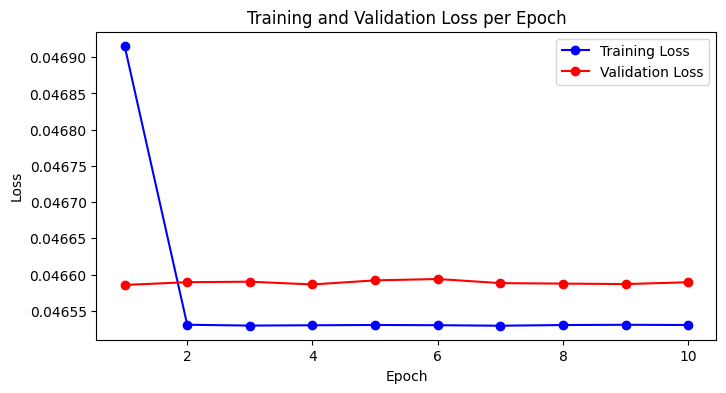
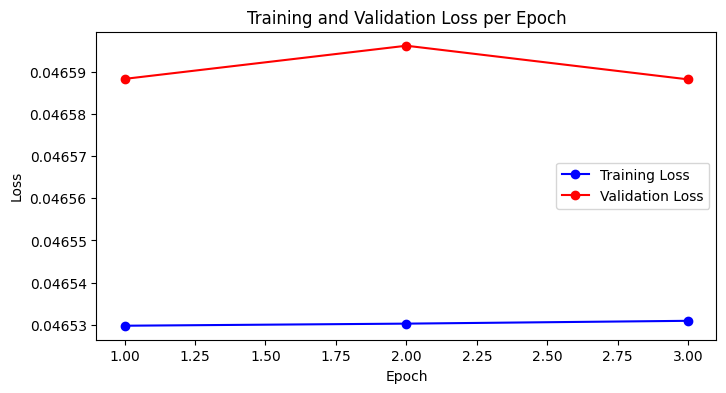

In [ ]:
epochs = 3
batch_size = 32

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

In [ ]:
# Save the entire model to a file
model.save("tf_model_v2.h5")

In [ ]:
print(y_test[1:3])
y_pred_0 = model.predict(X_test[1:3])
print(y_pred_0)

In [ ]:
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")

# Predictions
y_pred = model.predict(X_test)


In [ ]:
# Extracting loss and validation loss values
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Creating epoch numbers (starting from 1)
epochs_range = range(1, epochs + 1)

# Plotting the training and validation loss
plt.figure(figsize=(8, 4))
plt.plot(epochs_range, training_loss, 'bo-', label='Training Loss')
plt.plot(epochs_range, validation_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:

# Assuming combined_csv_data is your DataFrame and it has been loaded already



# Before splitting, ensure there are no NaN values in your output columns
for col in output_columns:
    combined_csv_data[col].fillna(0, inplace=True)  # Replace NaN in y with 0, if appropriate

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(combined_csv_data[input_columns], combined_csv_data[output_columns], test_size=0.2, random_state=42)

predictions = {}

for output_col in output_columns:
    # Create a pipeline with an imputer (to fill missing values in features) and logistic regression
    pipeline = make_pipeline(
        SimpleImputer(strategy='mean'),  # Fills missing X values with the mean of each column
        LogisticRegression(max_iter=1000)  # Increased max_iter to ensure convergence
    )
    
    # Fit the pipeline to the training data
    pipeline.fit(X_train, y_train[output_col])
    
    # New data for prediction. This example is simplified and should be replaced with actual new data.
    # Ensure X_new has the same number of features as X_train. Here, we use np.nan as placeholders.
    X_new = np.array([[0.5, 1.2] + [np.nan] * (224)])  # Adjusted to match the feature count of the trained model
    
    # Predicting the probability for the given X_new
    pred_prob = pipeline.predict_proba(X_new)[0][1]
    
    # Storing the prediction
    predictions[output_col] = pred_prob

# Displaying the predicted probabilities
for y_col, prob in predictions.items():
    print(f"Predicted probability for {y_col}: {prob:.2%}")


In [ ]:

warnings.filterwarnings("ignore", message="X does not have valid feature names, but SimpleImputer was fitted with feature names")

# Assuming combined_csv_data is your DataFrame and it has been loaded already
# Replace 'combined_csv_data' with the actual variable name of your DataFrame

# Fill missing values in output columns with a default value (e.g., 0)
y.fillna(0, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Dictionary to store the pipeline for each output column
pipelines = {}

# Train a pipeline for each output column
for output_col in output_columns:
    pipeline = make_pipeline(
        SimpleImputer(strategy='mean'),  # Impute missing values
        LogisticRegression(max_iter=1000)  # Logistic regression
    )
    # Fit the pipeline on the training data
    pipeline.fit(X_train, y_train[output_col])
    pipelines[output_col] = pipeline

# Predicting the probabilities for each row in X_test
predictions = {col: [] for col in output_columns}  # Initialize dictionary to store predictions

for index, row in X_test.iterrows():
    for output_col in output_columns:
        # Predict the probability for the current row and output column
        pred_prob = pipelines[output_col].predict_proba(row.values.reshape(1, -1))[0][1]
        predictions[output_col].append(pred_prob)

# Optionally, print out the predicted probabilities for the first few rows of X_test
for i, (index, row) in enumerate(X_test.iterrows()):
    if i >= 5:  # Limit output to first 5 rows
        break
    print(f"Predictions for row {index}:")
    for output_col in output_columns:
        print(f"  {output_col}: {predictions[output_col][i]:.2%}")
    print()  # Newline for readability


In [ ]:
warnings.filterwarnings("ignore", message="X does not have valid feature names, but SimpleImputer was fitted with feature names")

# Assuming combined_csv_data is your DataFrame and it has been loaded already
# Replace 'combined_csv_data' with the actual variable name of your DataFrame

# Fill missing values in output columns with a default value (e.g., 0)
y.fillna(0, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Dictionary to store the pipeline for each output column
pipelines = {}

# Train a pipeline for each output column
for output_col in output_columns:
    pipeline = make_pipeline(
        SimpleImputer(strategy='mean'),  # Impute missing values
        LogisticRegression(max_iter=1000)  # Logistic regression
    )
    # Fit the pipeline on the training data
    pipeline.fit(X_train, y_train[output_col])
    pipelines[output_col] = pipeline

# Predicting the probabilities for each row in X_test
predictions = {col: [] for col in output_columns}  # Initialize dictionary to store predictions

for index, row in X_test.iterrows():
    for output_col in output_columns:
        # Predict the probability for the current row and output column
        pred_prob = pipelines[output_col].predict_proba(row.values.reshape(1, -1))[0][1]
        predictions[output_col].append(pred_prob)

# Optionally, print out the predicted probabilities for the first few rows of X_test
for i, (index, row) in enumerate(X_test.iterrows()):
    if i >= 5:  # Limit output to first 5 rows
        break
    print(f"Predictions for row {index}:")
    for output_col in output_columns:
        print(f"  {output_col}: {predictions[output_col][i]:.2%}")
    print()  # Newline for readability


In [ ]:
class Phone:
    def __init__(self, data_df):
        self.data_df = data_df  # Assume data_df is a DataFrame loaded with user data

    def collect_data(self, userid):
        """Collects a random data row for a given user."""
        user_data = self.data_df[self.data_df['user_id'] == userid].sample(n=1)
        return user_data

    def process_data(self, userid, model):
        """Processes data using a specified model."""
        data = self.collect_data(userid)
        # Assuming `model` is a function passed to process the data
        processed_data = model(data)
        return processed_data

    def send_data(self, userid, interval, server):
        """Periodically sends data at specified intervals."""
        data = self.collect_data(userid)
        server.store_update_data(data)
        Timer(interval, self.send_data, args=[userid, interval, server]).start()

class Server:
    def __init__(self):
        self.storage_df = pd.DataFrame()  # Separate DataFrame for storing data

    def request_data(self, phone, userid, raw=True):
        """Requests data from the Phone class."""
        if raw:
            return phone.collect_data(userid)
        else:
            return phone.process_data(userid, self.process_data)  # Example: self.process_data as a placeholder

    def process_data(self, data):
        """Processes data."""
        # This is a placeholder for data processing logic, which could involve ML models or other transformations
        processed_data = data  # Simplified for demonstration
        return processed_data

    def store_update_data(self, data):
        """Stores or updates data in a separate DataFrame."""
        self.storage_df = pd.concat([self.storage_df, data], ignore_index=True)




In [ ]:
data_df = pd.read_csv('ExtraSensory_Combined_User_Data.csv')

In [ ]:
phone = Phone(data_df)
server = Server()

In [ ]:
userid="81536B0A-8DBF-4D8A-AC24-9543E2E4C8E0"
raw_data = server.request_data(phone, userid, raw=True)
processed_data = server.request_data(phone, userid, raw=False)
server.store_update_data(raw_data)
server.store_update_data(processed_data)

In [ ]:
server.storage_df